# 01_data_build_colored
- Author: 정재훈
- Date: 2025-11-10
- Goal: Colored MNIST 생성(색/배경 옵션)
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [4]:
# ============================================================
# 01_preprocessing_colored_mnist.ipynb
#
# Preprocessing pipeline for Colored MNIST:
#   1) Load MNIST
#   2) Deskew digits (no OpenCV; pure numpy + PIL)
#   3) Colorize digits (random FG/BG colors)
#   4) Add font-based digits (from TTF/OTF files)
#   5) Geometric data augmentation to reach TARGET_TOTAL samples
#   6) Train/Val/Test split
#   7) Standardize flattened features
#
# Output:
#   data/processed/colored_mnist/colored_mnist.npz
# ============================================================

import os  # filesystem paths
import random  # python-level RNG
import numpy as np  # numerical operations

import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # nicer plotting style

from sklearn.preprocessing import StandardScaler  # feature scaling
from sklearn.model_selection import train_test_split  # split train/val/test

from PIL import Image, ImageDraw, ImageFont  # font rendering & affine transform

# Reproducibility
SEED = 42  # global random seed
np.random.seed(SEED)  # numpy seed
random.seed(SEED)  # python random seed

# Matplotlib style (English only to avoid font issues)
plt.rcParams["font.family"] = "DejaVu Sans"  # default font
plt.rcParams["axes.unicode_minus"] = False  # minus sign display
sns.set(style="whitegrid")  # seaborn style

print("[OK] Libraries imported and global configuration set.")

[OK] Libraries imported and global configuration set.


In [5]:
# ------------------------------------------------------------
# [Cell 2] Resolve repo paths and load MNIST npz file
#   - Expecting: data/raw/mnist/mnist_train.npz
#   - Keys: 'train_images' (N,28,28), 'train_labels' (N,)
# ------------------------------------------------------------

cwd = os.getcwd()  # current working directory

# If we are inside "notebooks", move one level up to repo root
if os.path.basename(cwd) == "notebooks":
    BASE_DIR = os.path.dirname(cwd)  # repo root
else:
    BASE_DIR = cwd  # already at repo root

RAW_MNIST_PATH = os.path.join(BASE_DIR, "data", "raw", "mnist", "mnist_train.npz")  # MNIST npz path
FONTS_DIR = os.path.join(BASE_DIR, "data", "raw", "fonts")  # directory for TTF/OTF fonts
OUT_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")  # output directory for processed data
os.makedirs(OUT_DIR, exist_ok=True)  # create output directory if not exists

OUT_NPZ = os.path.join(OUT_DIR, "colored_mnist.npz")  # final npz file path

print(f"[INFO] BASE_DIR       : {BASE_DIR}")
print(f"[INFO] RAW_MNIST_PATH : {RAW_MNIST_PATH}")
print(f"[INFO] FONTS_DIR      : {FONTS_DIR}")
print(f"[INFO] OUT_NPZ        : {OUT_NPZ}")

if not os.path.exists(RAW_MNIST_PATH):  # check if MNIST npz exists
    raise FileNotFoundError(
        f"[ERROR] MNIST npz not found at {RAW_MNIST_PATH}.\n"
        f"Please place 'mnist_train.npz' under data/raw/mnist/."
    )

mnist = np.load(RAW_MNIST_PATH)  # load npz file
print("[INFO] mnist_train.npz keys:", list(mnist.keys()))

X_gray_all = mnist["train_images"].astype(np.float32)  # shape (N, 28, 28), grayscale 0~255
y_digit_all = mnist["train_labels"].astype(np.int64)   # shape (N,), digit labels 0~9

print("[OK] Loaded MNIST:")
print("  X_gray_all :", X_gray_all.shape)
print("  y_digit_all:", y_digit_all.shape)

[INFO] BASE_DIR       : c:\Users\CHOI\colored-mnist-classification
[INFO] RAW_MNIST_PATH : c:\Users\CHOI\colored-mnist-classification\data\raw\mnist\mnist_train.npz
[INFO] FONTS_DIR      : c:\Users\CHOI\colored-mnist-classification\data\raw\fonts
[INFO] OUT_NPZ        : c:\Users\CHOI\colored-mnist-classification\data\processed\colored_mnist\colored_mnist.npz
[INFO] mnist_train.npz keys: ['train_images', 'train_labels']
[OK] Loaded MNIST:
  X_gray_all : (60000, 28, 28)
  y_digit_all: (60000,)


In [6]:
# ------------------------------------------------------------
# [Cell 3] Define ROYG BIV color palette
#   - 7 colors, used as foreground/background
#   - Values stored in [0,1] RGB format
# ------------------------------------------------------------

COLOR_NAMES = ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]  # color names

COLOR_VALUES = np.array([  # RGB values in [0,1]
    [1.0, 0.0, 0.0],   # red
    [1.0, 0.5, 0.0],   # orange
    [1.0, 1.0, 0.0],   # yellow
    [0.0, 0.6, 0.0],   # green
    [0.0, 0.0, 1.0],   # blue
    [0.3, 0.0, 0.5],   # indigo
    [0.8, 0.0, 0.8],   # violet
], dtype=np.float32)

NUM_COLORS = len(COLOR_NAMES)  # number of colors

print("[OK] Color palette defined:", COLOR_NAMES)

[OK] Color palette defined: ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']


[DEBUG] X_gray_all dtype/shape: float32 (60000, 28, 28)
[DEBUG] one sample type/shape: <class 'numpy.ndarray'> (28, 28)


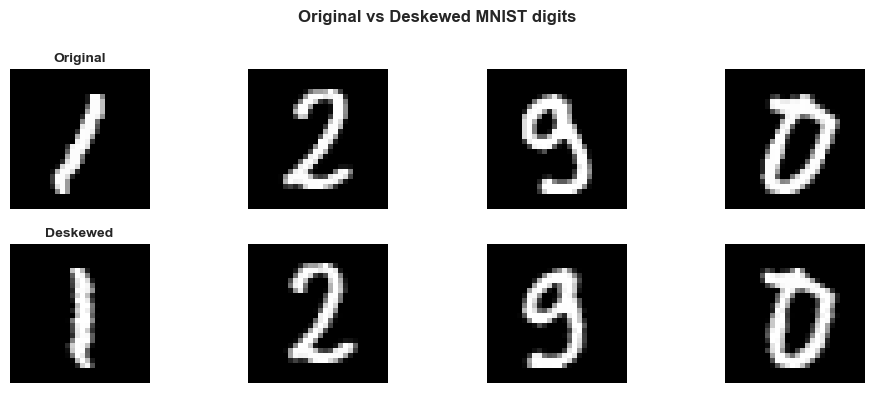

In [19]:
# ------------------------------------------------------------
# [Cell 4] Deskew function using pure numpy + PIL
#   - Moments (m00, m10, m01, mu11, mu02) computed with numpy
#   - Horizontal shear applied using PIL.Image.transform
# ------------------------------------------------------------

def compute_moments(image_2d: np.ndarray, eps: float = 1e-4):
    """Compute basic raw and central moments for a 2D grayscale image.
    
    Parameters
    ----------
    image_2d : np.ndarray
        2D grayscale image (H,W).
    eps : float
        Small constant to avoid division by zero.
    
    Returns
    -------
    m00 : float
        Zeroth-order moment (sum of intensities).
    mu11 : float
        Central mixed moment (x,y).
    mu02 : float
        Central moment for y-direction.
    """
    img = np.asarray(image_2d).astype(np.float32)  # ensure float32 numpy array
    h, w = img.shape  # image height and width

    # If image is almost empty, return zeros
    m00 = img.sum()  # total intensity
    if m00 < eps:
        return m00, 0.0, 0.0

    # Build coordinate grids
    y, x = np.mgrid[0:h, 0:w]  # y: rows, x: columns

    # Raw first-order moments
    m10 = (x * img).sum()
    m01 = (y * img).sum()

    # Centroid coordinates
    x_bar = m10 / m00
    y_bar = m01 / m00

    # Central moments
    x_shifted = x - x_bar
    y_shifted = y - y_bar

    mu11 = (x_shifted * y_shifted * img).sum()   # mixed central moment
    mu02 = (y_shifted ** 2 * img).sum()          # vertical variance moment

    return m00, mu11, mu02


def deskew(image_2d: np.ndarray, eps: float = 1e-4) -> np.ndarray:
    """Deskew a single digit image using shear transform via PIL.
    
    Parameters
    ----------
    image_2d : np.ndarray
        2D grayscale digit image (28x28).
    eps : float
        Small constant to avoid division by zero.

    Returns
    -------
    np.ndarray
        Deskewed 2D image (28x28), dtype float32.
    """
    img = np.asarray(image_2d).astype(np.float32)  # ensure float32
    if img.ndim != 2:  # safety check for dimensionality
        raise ValueError(f"deskew() expects 2D image, got shape {img.shape}")

    # Normalize to [0,255] for moment computation if needed
    if img.max() <= 1.0 + 1e-6:
        img_m = img * 255.0  # scale up for stable moments
    else:
        img_m = img.copy()

    # Compute basic moments
    m00, mu11, mu02 = compute_moments(img_m, eps=eps)

    # If image is empty or has almost no vertical variance, skip deskew
    if m00 < eps or abs(mu02) < eps:
        return img

    # Skew factor based on central moments
    skew = mu11 / mu02  # same definition as in classic MNIST deskew

    # Build shear transform matrix for PIL
    # We want: x' = x + skew*(y - h/2), y' = y
    # PIL's affine uses: x_in = a*x + b*y + c, y_in = d*x + e*y + f
    # So we set a=1, b=skew, c=-skew*h/2, d=0, e=1, f=0
    h, w = img.shape  # height and width
    a = 1.0
    b = skew
    c = -skew * (h / 2.0)
    d = 0.0
    e = 1.0
    f = 0.0

    pil_img = Image.fromarray(img_m.astype(np.uint8))  # convert to PIL image
    deskewed_pil = pil_img.transform(
        size=(w, h),  # output size
        method=Image.AFFINE,  # affine transform
        data=(a, b, c, d, e, f),  # affine parameters
        resample=Image.BICUBIC,  # interpolation method
        fillcolor=0  # fill empty pixels with black
    )

    # Convert back to float32 and re-normalize to original range [0,1] or [0,255]
    deskewed = np.array(deskewed_pil).astype(np.float32)
    if img.max() <= 1.0 + 1e-6:
        deskewed = deskewed / 255.0  # back to [0,1]
    return deskewed


# Quick EDA: visualize Original vs Deskewed digits
n_samples_to_show = 4  # number of digits to visualize
idxs = np.random.choice(len(X_gray_all), n_samples_to_show, replace=False)  # random indices

print("[DEBUG] X_gray_all dtype/shape:", X_gray_all.dtype, X_gray_all.shape)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(idxs):
    original = X_gray_all[idx]          # original digit
    if i == 0:  # print debug info for the first sample
        print("[DEBUG] one sample type/shape:", type(original), np.asarray(original).shape)
    fixed = deskew(original)            # deskewed digit

    # Top row: original
    plt.subplot(2, n_samples_to_show, i + 1)
    plt.imshow(original, cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original", fontsize=10, fontweight='bold')

    # Bottom row: deskewed
    plt.subplot(2, n_samples_to_show, i + 1 + n_samples_to_show)
    plt.imshow(fixed, cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Deskewed", fontsize=10, fontweight='bold')

plt.suptitle("Original vs Deskewed MNIST digits", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
# ------------------------------------------------------------
# [Cell 5] Colorization utilities
#   - apply_color_to_digit: grayscale -> RGB (28x28x3) using FG/BG colors
#   - random_fg_bg_indices: sample valid FG/BG indices (fg != bg)
# ------------------------------------------------------------

def apply_color_to_digit(gray_img: np.ndarray,
                         fg_idx: int,
                         bg_idx: int) -> np.ndarray:
    """Colorize a grayscale digit image using foreground and background colors.
    
    Parameters
    ----------
    gray_img : np.ndarray
        2D grayscale digit (28x28).
    fg_idx : int
        Index of foreground color (0~6).
    bg_idx : int
        Index of background color (0~6), must differ from fg_idx.
    
    Returns
    -------
    np.ndarray
        RGB image (28,28,3) with values in [0,1].
    """
    img = np.asarray(gray_img).astype(np.float32)  # ensure float32
    # Normalize grayscale to [0,1]
    if img.max() > 1.0 + 1e-6:
        img = img / 255.0  # convert from [0,255] to [0,1]

    fg_color = COLOR_VALUES[fg_idx]  # foreground RGB color (3,)
    bg_color = COLOR_VALUES[bg_idx]  # background RGB color (3,)

    alpha = img[..., None]  # treat intensity as alpha mask, shape (28,28,1)

    # Linear interpolation between fg and bg
    rgb = alpha * fg_color + (1.0 - alpha) * bg_color  # shape (28,28,3)

    return rgb.astype(np.float32)


def random_fg_bg_indices():
    """Sample a valid pair of foreground and background color indices."""
    fg_idx = np.random.randint(0, NUM_COLORS)  # random foreground
    bg_idx = np.random.randint(0, NUM_COLORS)  # random background
    while bg_idx == fg_idx:  # ensure they are different
        bg_idx = np.random.randint(0, NUM_COLORS)
    return fg_idx, bg_idx

In [ ]:
# ------------------------------------------------------------
# [Cell 6-1] Build base Colored MNIST from deskewed MNIST digits
#   - 1) Deskew all digits
#   - 2) Assign random FG/BG for each digit
#   - 3) Generate RGB images (28x28x3) in [0,1]
# ------------------------------------------------------------

deskewed_digits = np.zeros_like(X_gray_all, dtype=np.float32)  # container for deskewed images

for i in range(len(X_gray_all)):  # iterate over all MNIST samples
    deskewed_digits[i] = deskew(X_gray_all[i])  # apply deskew function

print("[OK] Deskewed all MNIST digits:", deskewed_digits.shape)

base_rgb_list = []  # list of RGB images
base_fg_list = []   # list of foreground color indices
base_bg_list = []   # list of background color indices

for i in range(len(deskewed_digits)):  # loop over deskewed digits
    fg_idx, bg_idx = random_fg_bg_indices()       # sample color pair
    rgb = apply_color_to_digit(deskewed_digits[i], fg_idx, bg_idx)  # colorize digit

    base_rgb_list.append(rgb)  # store RGB image
    base_fg_list.append(fg_idx)  # store fg color index
    base_bg_list.append(bg_idx)  # store bg color index

X_base_rgb = np.stack(base_rgb_list, axis=0)  # (N_base, 28,28,3)
y_base_digit = y_digit_all.copy()             # digit labels
y_base_fg = np.array(base_fg_list, dtype=np.int64)  # fg labels
y_base_bg = np.array(base_bg_list, dtype=np.int64)  # bg labels

print("[OK] Base Colored MNIST built:")
print("  X_base_rgb :", X_base_rgb.shape)
print("  y_base_digit:", y_base_digit.shape)

[OK] Deskewed all MNIST digits: (60000, 28, 28)
[OK] Base Colored MNIST built:
  X_base_rgb : (60000, 28, 28, 3)
  y_base_digit: (60000,)


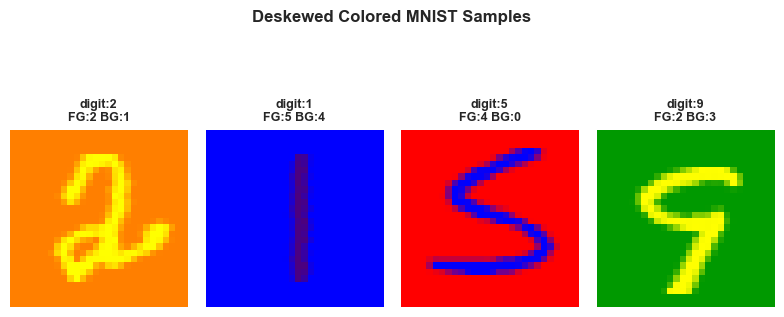

In [31]:
# ------------------------------------------------------------
# [Cell 6-2: visualize] Visualize random samples of Deskewed Colored MNIST
# ------------------------------------------------------------

n_show = 4
idxs = np.random.choice(len(X_base_rgb), n_show, replace=False)

plt.figure(figsize=(8, 4))

for i, idx in enumerate(idxs):
    img_rgb = X_base_rgb[idx]
    digit_label = y_base_digit[idx]
    fg_label = y_base_fg[idx]
    bg_label = y_base_bg[idx]

    plt.subplot(1, n_show, i+1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(
        f"digit:{digit_label}\nFG:{fg_label} BG:{bg_label}",
        fontsize=9, fontweight="bold"
    )

plt.suptitle("Deskewed Colored MNIST Samples", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


[INFO] Found 5 font files.


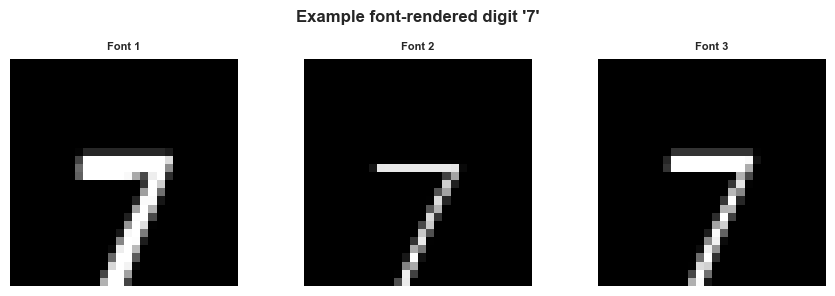

In [34]:
# ------------------------------------------------------------
# [Cell 7] Font path discovery and digit rendering
#   - find_font_paths: find .ttf/.otf files under FONTS_DIR
#   - render_digit_with_font: render '0'~'9' using given font
# ------------------------------------------------------------

def find_font_paths(font_root: str):
    """Recursively collect all .ttf and .otf font paths under a root directory."""
    if not os.path.exists(font_root):  # directory does not exist
        print(f"[WARN] Font directory not found: {font_root}")
        return []

    font_paths = []
    for root, _, files in os.walk(font_root):  # walk through all subdirectories
        for f in files:
            if f.lower().endswith((".ttf", ".otf")):  # font file extensions
                font_paths.append(os.path.join(root, f))

    return font_paths


def render_digit_with_font(digit: int,
                           font_path: str,
                           img_size: int = 28,
                           font_size: int = 24):
    """Render a digit using a given TTF/OTF font into a 28x28 grayscale image.
    
    Parameters
    ----------
    digit : int
        Digit value 0~9.
    font_path : str
        File path to a TTF/OTF font.
    img_size : int
        Output image size (img_size x img_size).
    font_size : int
        Font size used to draw the digit.

    Returns
    -------
    np.ndarray or None
        Grayscale image (img_size, img_size) with values in [0,255],
        or None if rendering fails.
    """
    try:
        # Create blank grayscale image (L mode) with black background
        img = Image.new("L", (img_size, img_size), color=0)
        draw = ImageDraw.Draw(img)

        # Load the font with given size
        font = ImageFont.truetype(font_path, font_size)

        text = str(digit)  # convert integer to string
        bbox = draw.textbbox((0, 0), text, font=font)  # bounding box of rendered text
        w = bbox[2] - bbox[0]  # text width
        h = bbox[3] - bbox[1]  # text height

        # Center text within the 28x28 canvas
        x = (img_size - w) // 2  # left coordinate
        y = (img_size - h) // 2  # top coordinate

        # Draw white digit (255) on black background
        draw.text((x, y), text, fill=255, font=font)

        arr = np.array(img, dtype=np.uint8)  # convert PIL image to numpy array
        return arr
    except Exception as e:
        print(f"[WARN] Failed to render digit {digit} with font {font_path}: {e}")
        return None


font_paths = find_font_paths(FONTS_DIR)  # collect all font files
print(f"[INFO] Found {len(font_paths)} font files.")

# Quick EDA: show some rendered font digits if fonts exist
n_fonts_preview = min(3, len(font_paths))  # at most 3 fonts for preview
if n_fonts_preview > 0:
    plt.figure(figsize=(3 * n_fonts_preview, 3))
    for i, fpath in enumerate(font_paths[:n_fonts_preview]):
        img = render_digit_with_font(7, fpath)  # render digit '7'
        if img is None:
            continue
        plt.subplot(1, n_fonts_preview, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Font {i+1}", fontsize=8, fontweight="bold")
    plt.suptitle("Example font-rendered digit '7'", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] No font files found; font-based digits may be skipped.")

In [11]:
# ------------------------------------------------------------
# [Cell 8] Build font-based Colored MNIST subset (with deskew)
#   - For each font, render multiple samples per digit
#   - Apply deskew, then colorization
# ------------------------------------------------------------

def build_font_colored(font_paths,
                       digits=range(10),
                       samples_per_digit_per_font: int = 50):
    """Build a font-based Colored MNIST subset using deskew + colorization.
    
    Parameters
    ----------
    font_paths : list of str
        List of font file paths.
    digits : iterable of int
        Digits to render (default 0~9).
    samples_per_digit_per_font : int
        Number of samples per (digit, font) pair.

    Returns
    -------
    X_font_rgb : np.ndarray or None
        RGB images (N_font, 28,28,3) in [0,1],
        or None if no valid samples generated.
    y_digit_font : np.ndarray
        Digit labels (N_font,).
    y_fg_font : np.ndarray
        Foreground color labels (N_font,).
    y_bg_font : np.ndarray
        Background color labels (N_font,).
    """
    if len(font_paths) == 0:
        return None, None, None, None

    rgb_list = []  # RGB images
    digit_list = []  # digit labels
    fg_list = []  # foreground colors
    bg_list = []  # background colors

    for f_idx, font_path in enumerate(font_paths):
        print(f"[FONT] Processing font {f_idx+1}/{len(font_paths)}: {os.path.basename(font_path)}")
        for d in digits:
            for _ in range(samples_per_digit_per_font):
                gray = render_digit_with_font(d, font_path)
                if gray is None:
                    continue

                # Apply deskew to font-rendered digit
                gray_deskew = deskew(gray)

                # Random foreground / background colors
                fg_idx, bg_idx = random_fg_bg_indices()
                rgb = apply_color_to_digit(gray_deskew, fg_idx, bg_idx)

                rgb_list.append(rgb)
                digit_list.append(d)
                fg_list.append(fg_idx)
                bg_list.append(bg_idx)

    if len(rgb_list) == 0:
        print("[INFO] No valid font-based samples generated. Skip.")
        return None, None, None, None

    X_font_rgb = np.stack(rgb_list, axis=0).astype(np.float32)
    y_digit_font = np.array(digit_list, dtype=np.int64)
    y_fg_font = np.array(fg_list, dtype=np.int64)
    y_bg_font = np.array(bg_list, dtype=np.int64)

    return X_font_rgb, y_digit_font, y_fg_font, y_bg_font


X_font_rgb, y_font_digit, y_font_fg, y_font_bg = build_font_colored(font_paths)

if X_font_rgb is not None:
    print("[OK] Font-based Colored MNIST built:")
    print("  X_font_rgb :", X_font_rgb.shape)
    print("  y_font_digit:", y_font_digit.shape)
else:
    print("[INFO] Font-based subset will be skipped (no fonts or rendering failure).")

[FONT] Processing font 1/5: MaruBuri-Bold.ttf


[FONT] Processing font 2/5: MaruBuri-ExtraLight.ttf
[FONT] Processing font 3/5: MaruBuri-Light.ttf
[FONT] Processing font 4/5: MaruBuri-Regular.ttf
[FONT] Processing font 5/5: MaruBuri-SemiBold.ttf
[OK] Font-based Colored MNIST built:
  X_font_rgb : (2500, 28, 28, 3)
  y_font_digit: (2500,)


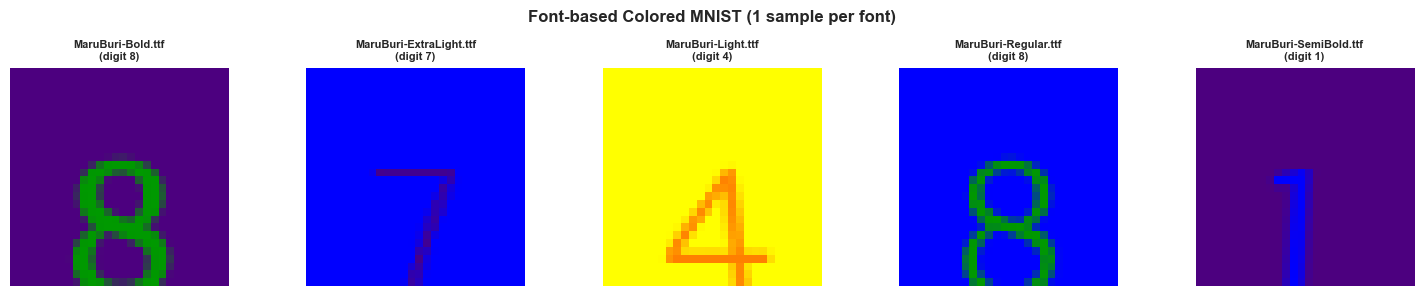

In [35]:
# ------------------------------------------------------------
# [Cell 8-visualize] Show 1 sample per font (total 5 fonts)
# ------------------------------------------------------------

n_fonts_preview = min(5, len(font_paths))  # 최대 5개 폰트만 보여줌

plt.figure(figsize=(3 * n_fonts_preview, 3))

for i in range(n_fonts_preview):
    fpath = font_paths[i]

    # 이 폰트로 숫자 하나 랜덤 렌더링
    d = np.random.randint(0, 10)  # 0~9 중 하나
    gray = render_digit_with_font(d, fpath)

    if gray is None:
        continue

    # deskew → 컬러 적용
    gray_ds = deskew(gray)
    fg_idx, bg_idx = random_fg_bg_indices()
    rgb = apply_color_to_digit(gray_ds, fg_idx, bg_idx)

    plt.subplot(1, n_fonts_preview, i + 1)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(f"{os.path.basename(fpath)}\n(digit {d})",
              fontsize=8, fontweight='bold')

plt.suptitle("Font-based Colored MNIST (1 sample per font)",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


In [12]:
# ------------------------------------------------------------
# [Cell 9] Merge base and font subsets into one dataset
#   - y_source: 0 for base MNIST, 1 for font
# ------------------------------------------------------------

X_list = [X_base_rgb]  # list of image arrays
y_digit_list = [y_base_digit]  # list of digit label arrays
y_fg_list = [y_base_fg]  # list of fg label arrays
y_bg_list = [y_base_bg]  # list of bg label arrays
y_source_list = [np.zeros(len(X_base_rgb), dtype=np.int64)]  # 0 = base dataset

if X_font_rgb is not None:
    X_list.append(X_font_rgb)  # append font images
    y_digit_list.append(y_font_digit)  # append font digit labels
    y_fg_list.append(y_font_fg)  # append font fg labels
    y_bg_list.append(y_font_bg)  # append font bg labels
    y_source_list.append(np.ones(len(X_font_rgb), dtype=np.int64))  # 1 = font dataset

X_all_rgb = np.concatenate(X_list, axis=0)  # merged images, shape (N_all,28,28,3)
y_all_digit = np.concatenate(y_digit_list, axis=0)  # merged digit labels
y_all_fg = np.concatenate(y_fg_list, axis=0)  # merged fg labels
y_all_bg = np.concatenate(y_bg_list, axis=0)  # merged bg labels
y_all_source = np.concatenate(y_source_list, axis=0)  # merged source labels

N_all = X_all_rgb.shape[0]  # total sample count
print("[OK] Merged base + font subsets:")
print("  X_all_rgb   :", X_all_rgb.shape)
print("  y_all_digit :", y_all_digit.shape)
print("  unique sources (0=base,1=font):", np.unique(y_all_source, return_counts=True))

[OK] Merged base + font subsets:
  X_all_rgb   : (62500, 28, 28, 3)
  y_all_digit : (62500,)
  unique sources (0=base,1=font): (array([0, 1]), array([60000,  2500]))


In [13]:
# ------------------------------------------------------------
# [Cell 10] Data augmentation on RGB images using PIL (rotate + translate)
#   - augment_rgb_image: apply random rotation and shift
#   - Extend dataset until TARGET_TOTAL samples
# ------------------------------------------------------------

def augment_rgb_image(rgb_img: np.ndarray,
                      max_shift: int = 2,
                      max_angle: float = 10.0) -> np.ndarray:
    """Apply geometric augmentation (rotation + translation) to an RGB image.
    
    Parameters
    ----------
    rgb_img : np.ndarray
        Input RGB image (28,28,3) with values in [0,1].
    max_shift : int
        Maximum translation in pixels (both x and y).
    max_angle : float
        Maximum rotation angle in degrees.

    Returns
    -------
    np.ndarray
        Augmented RGB image (28,28,3) in [0,1].
    """
    img = np.asarray(rgb_img).astype(np.float32)  # ensure float32
    h, w, c = img.shape  # expect (28,28,3)

    # Convert to uint8 [0,255] for PIL
    img_uint8 = np.clip(img * 255.0, 0, 255).astype(np.uint8)

    # Create PIL Image from numpy array
    pil_img = Image.fromarray(img_uint8, mode="RGB")

    # Random rotation angle
    angle = np.random.uniform(-max_angle, max_angle)
    # Random shift in x and y
    tx = np.random.randint(-max_shift, max_shift + 1)
    ty = np.random.randint(-max_shift, max_shift + 1)

    # Rotate + translate; expand=False keeps size (28,28)
    # fillcolor=(0,0,0) = black background for empty areas
    aug_pil = pil_img.rotate(
        angle,
        resample=Image.BICUBIC,
        expand=False,
        translate=(tx, ty),
        fillcolor=(0, 0, 0),
    )

    # Convert back to numpy float32 in [0,1]
    aug = np.array(aug_pil).astype(np.float32) / 255.0
    return aug


TARGET_TOTAL = 70000  # desired total dataset size

N_current = X_all_rgb.shape[0]  # current number of samples
print(f"[INFO] Current dataset size (base+font) = {N_current}")

if N_current >= TARGET_TOTAL:
    print("[INFO] No augmentation needed; dataset already >= TARGET_TOTAL.")
    X_final_rgb = X_all_rgb
    y_final_digit = y_all_digit
    y_final_fg = y_all_fg
    y_final_bg = y_all_bg
    y_final_source = y_all_source
else:
    n_aug = TARGET_TOTAL - N_current  # number of augmented samples required
    print(f"[INFO] Need {n_aug} augmented samples to reach {TARGET_TOTAL}.")

    aug_rgb_list = []     # augmented images
    aug_digit_list = []   # augmented digit labels
    aug_fg_list = []      # augmented fg labels
    aug_bg_list = []      # augmented bg labels
    aug_source_list = []  # source label 2 for augmented

    # Randomly sample indices from existing dataset for augmentation
    idxs = np.random.choice(N_current, n_aug, replace=True)

    for idx in idxs:
        rgb = X_all_rgb[idx]
        digit = y_all_digit[idx]
        fg = y_all_fg[idx]
        bg = y_all_bg[idx]

        rgb_aug = augment_rgb_image(rgb)  # apply augmentation

        aug_rgb_list.append(rgb_aug)
        aug_digit_list.append(digit)
        aug_fg_list.append(fg)
        aug_bg_list.append(bg)
        aug_source_list.append(2)  # 2 = augmented data

    X_aug_rgb = np.stack(aug_rgb_list, axis=0).astype(np.float32)
    y_aug_digit = np.array(aug_digit_list, dtype=np.int64)
    y_aug_fg = np.array(aug_fg_list, dtype=np.int64)
    y_aug_bg = np.array(aug_bg_list, dtype=np.int64)
    y_aug_source = np.array(aug_source_list, dtype=np.int64)

    # Concatenate original and augmented data
    X_final_rgb = np.concatenate([X_all_rgb, X_aug_rgb], axis=0)
    y_final_digit = np.concatenate([y_all_digit, y_aug_digit], axis=0)
    y_final_fg = np.concatenate([y_all_fg, y_aug_fg], axis=0)
    y_final_bg = np.concatenate([y_all_bg, y_aug_bg], axis=0)
    y_final_source = np.concatenate([y_all_source, y_aug_source], axis=0)

    print("[OK] Augmented dataset built:")
    print("  X_final_rgb   :", X_final_rgb.shape)
    print("  y_final_digit :", y_final_digit.shape)
    print("  sources (0=base,1=font,2=aug):", np.unique(y_final_source, return_counts=True))

print(f"[CHECK] Final dataset size: {X_final_rgb.shape[0]} (target={TARGET_TOTAL})")

[INFO] Current dataset size (base+font) = 62500
[INFO] Need 7500 augmented samples to reach 70000.
[OK] Augmented dataset built:
  X_final_rgb   : (70000, 28, 28, 3)
  y_final_digit : (70000,)
  sources (0=base,1=font,2=aug): (array([0, 1, 2]), array([60000,  2500,  7500]))
[CHECK] Final dataset size: 70000 (target=70000)


In [14]:
# ------------------------------------------------------------
# [Cell 11] Train/Val/Test split with stratification by digit
#   - First split: Train vs Temp (Val+Test)
#   - Second split: Val vs Test from Temp
# ------------------------------------------------------------

X_train_rgb, X_temp_rgb, \
y_digit_train, y_digit_temp, \
y_fg_train, y_fg_temp, \
y_bg_train, y_bg_temp, \
y_source_train, y_source_temp = train_test_split(
    X_final_rgb,
    y_final_digit,
    y_final_fg,
    y_final_bg,
    y_final_source,
    test_size=0.2,          # 80% train, 20% temp
    random_state=SEED,
    stratify=y_final_digit  # keep digit distribution balanced
)

X_val_rgb, X_test_rgb, \
y_digit_val, y_digit_test, \
y_fg_val, y_fg_test, \
y_bg_val, y_bg_test, \
y_source_val, y_source_test = train_test_split(
    X_temp_rgb,
    y_digit_temp,
    y_fg_temp,
    y_bg_temp,
    y_source_temp,
    test_size=0.5,          # 10% val, 10% test
    random_state=SEED,
    stratify=y_digit_temp
)

print("[OK] Train/Val/Test split completed:")
print("  X_train_rgb:", X_train_rgb.shape)
print("  X_val_rgb  :", X_val_rgb.shape)
print("  X_test_rgb :", X_test_rgb.shape)

[OK] Train/Val/Test split completed:
  X_train_rgb: (56000, 28, 28, 3)
  X_val_rgb  : (7000, 28, 28, 3)
  X_test_rgb : (7000, 28, 28, 3)


In [15]:
# ------------------------------------------------------------
# [Cell 12] Flatten RGB images and apply StandardScaler
#   - X_*_raw : flattened RGB features in [0,1]
#   - X_*     : standardized features (mean=0, std=1) for classical ML
# ------------------------------------------------------------

# Flatten (N,28,28,3) -> (N, 28*28*3)
X_train_raw = X_train_rgb.reshape(len(X_train_rgb), -1).astype(np.float32)
X_val_raw   = X_val_rgb.reshape(len(X_val_rgb), -1).astype(np.float32)
X_test_raw  = X_test_rgb.reshape(len(X_test_rgb), -1).astype(np.float32)

print("[INFO] Flattened raw feature shapes:")
print("  X_train_raw:", X_train_raw.shape)
print("  X_val_raw  :", X_val_raw.shape)
print("  X_test_raw :", X_test_raw.shape)

# StandardScaler using only train statistics
scaler = StandardScaler()  # create scaler object
X_train = scaler.fit_transform(X_train_raw)  # fit on train + transform
X_val   = scaler.transform(X_val_raw)        # transform val using train stats
X_test  = scaler.transform(X_test_raw)       # transform test using train stats

print("[OK] Standardization completed.")
print("  X_train mean/std (approx):", float(np.mean(X_train)), float(np.std(X_train)))

[INFO] Flattened raw feature shapes:
  X_train_raw: (56000, 2352)
  X_val_raw  : (7000, 2352)
  X_test_raw : (7000, 2352)
[OK] Standardization completed.
  X_train mean/std (approx): -4.1045530863037527e-10 0.9999992847442627


In [16]:
# ------------------------------------------------------------
# [Cell 13] EDA: source distribution and color distribution
# ------------------------------------------------------------

def print_source_stats(split_name, y_source_split):
    """Print distribution of source labels for a split."""
    unique, counts = np.unique(y_source_split, return_counts=True)
    print(f"[{split_name}] source distribution (0=base,1=font,2=aug):")
    for u, c in zip(unique, counts):
        print(f"  source={u}: count={c}")
    print("")


print_source_stats("Train", y_source_train)
print_source_stats("Val", y_source_val)
print_source_stats("Test", y_source_test)

print("[Train] Foreground color distribution:")
for idx, name in enumerate(COLOR_NAMES):
    count = np.sum(y_fg_train == idx)
    print(f"  {name}: {count}")

print("\n[Train] Background color distribution:")
for idx, name in enumerate(COLOR_NAMES):
    count = np.sum(y_bg_train == idx)
    print(f"  {name}: {count}")

[Train] source distribution (0=base,1=font,2=aug):
  source=0: count=48017
  source=1: count=1985
  source=2: count=5998

[Val] source distribution (0=base,1=font,2=aug):
  source=0: count=5995
  source=1: count=240
  source=2: count=765

[Test] source distribution (0=base,1=font,2=aug):
  source=0: count=5988
  source=1: count=275
  source=2: count=737

[Train] Foreground color distribution:
  red: 8034
  orange: 8054
  yellow: 7882
  green: 7939
  blue: 8211
  indigo: 7891
  violet: 7989

[Train] Background color distribution:
  red: 8009
  orange: 8045
  yellow: 7910
  green: 8055
  blue: 8045
  indigo: 7978
  violet: 7958


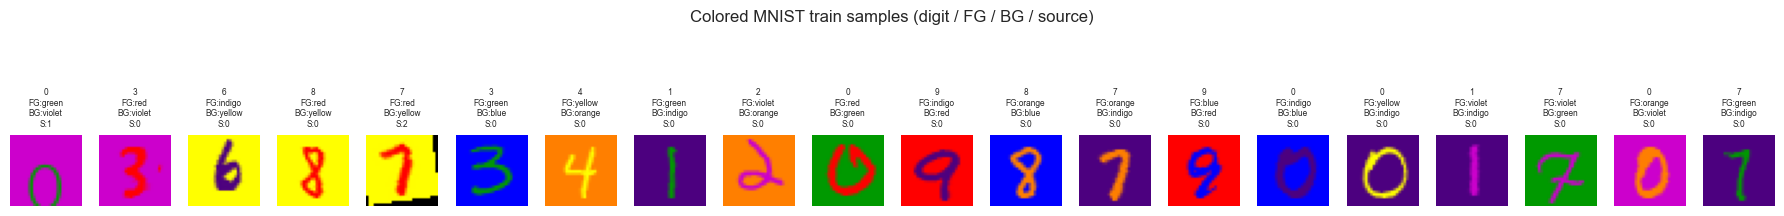

In [17]:
# ------------------------------------------------------------
# [Cell 14] Visualize random Colored MNIST samples from train split
#   - Title shows: digit / FG / BG / source
# ------------------------------------------------------------

def show_colored_samples(X_rgb, y_digit, y_fg, y_bg, y_source, n=20):
    """Visualize several Colored MNIST samples with basic labels."""
    n = min(n, len(X_rgb))  # limit number of samples
    idxs = np.random.choice(len(X_rgb), n, replace=False)  # random indices

    plt.figure(figsize=(n * 0.9, 3))
    for i, idx in enumerate(idxs):
        img = X_rgb[idx]
        d = y_digit[idx]
        fg_name = COLOR_NAMES[y_fg[idx]]
        bg_name = COLOR_NAMES[y_bg[idx]]
        src = y_source[idx]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg_name}\nBG:{bg_name}\nS:{src}", fontsize=6)
    plt.suptitle("Colored MNIST train samples (digit / FG / BG / source)", fontsize=12)
    plt.tight_layout()
    plt.show()


show_colored_samples(X_train_rgb, y_digit_train, y_fg_train, y_bg_train, y_source_train, n=20)

In [18]:
# ------------------------------------------------------------
# [Cell 15] Save processed dataset into a single npz file
#   - This file will be used by 02_train_classical_ml.ipynb
# ------------------------------------------------------------

np.savez_compressed(
    OUT_NPZ,
    X_train=X_train.astype(np.float32),
    X_val=X_val.astype(np.float32),
    X_test=X_test.astype(np.float32),

    X_train_raw=X_train_raw.astype(np.float32),
    X_val_raw=X_val_raw.astype(np.float32),
    X_test_raw=X_test_raw.astype(np.float32),

    y_digit_train=y_digit_train,
    y_digit_val=y_digit_val,
    y_digit_test=y_digit_test,

    y_fg_train=y_fg_train,
    y_fg_val=y_fg_val,
    y_fg_test=y_fg_test,

    y_bg_train=y_bg_train,
    y_bg_val=y_bg_val,
    y_bg_test=y_bg_test,

    y_source_train=y_source_train,
    y_source_val=y_source_val,
    y_source_test=y_source_test,
)

print(f"[DONE] Saved processed Colored MNIST to {OUT_NPZ}")

[DONE] Saved processed Colored MNIST to c:\Users\CHOI\colored-mnist-classification\data\processed\colored_mnist\colored_mnist.npz
